`<<<<<<< HEAD`

In [1]:
#| hide
import logging

# Turn off logging for datasets
logging.getLogger("datasets").setLevel(logging.ERROR)

import torch

torch.multiprocessing.set_start_method('spawn')# good solution !!!!

`=======`

In [ ]:
#| hide
import logging

# Turn off logging for datasets
logging.getLogger("datasets").setLevel(logging.ERROR)

`>>>>>>> da2631218c3ce46078ebd2300a91557e85df83bc`

# Tutorial - Code Analysis

> Explore the performance of code models on different code constructs!

`<<<<<<< HEAD`

In [2]:
!pip install -U git+https://github.com/ncoop57/code_tokenizers.git
!download_grammars

  Cloning https://github.com/ncoop57/code_tokenizers.git to /tmp/pip-req-build-vjimbq4_
  Running command git clone --filter=blob:none --quiet https://github.com/ncoop57/code_tokenizers.git /tmp/pip-req-build-vjimbq4_
  Resolved https://github.com/ncoop57/code_tokenizers.git to commit cdd8368b4ac26ee8bc4653664786224da52bbb46
  Preparing metadata (setup.py) ... done


In [19]:
from datasets import load_dataset

# dataset = load_dataset(
#   "codeparrot/github-code",
#   split="train",
#   streaming=True,
#   languages=["Python"],
#   licenses=["gpl-3.0"],
# )
ds = load_dataset("bigcode/the-stack-smol", data_dir="data/python", split="train").select(range(5_000))
filtered_ds = ds.filter(lambda example: len(example["content"]) < 4096)
len(filtered_ds)

Using custom data configuration bigcode--the-stack-smol-7b51f8bde3058781
Found cached dataset json (/home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-b38dcc32a872398b.arrow


3072

In [20]:
def find_duplicates(items):
  # Create an empty set to store the items that we have already seen
  seen = set()

  # Create an empty list to store the duplicates that we find
  duplicates = []

  # Loop through each item in the list
  for item in items:
    # If the item is already in the "seen" set, then it must be a duplicate
    if item in seen:
      # Add the duplicate to the list
      duplicates.append(item)
    # If the item is not in the "seen" set, then add it to the set
    else:
      seen.add(item)

  # Return the list of duplicates
  return duplicates

repo_names = find_duplicates(filtered_ds["repository_name"])

repo_files = {}
for repo_name in repo_names:
    rows_w_repo = filtered_ds.filter(lambda example: example["repository_name"] == repo_name)

    if len(rows_w_repo) > 1:
        repo_files[repo_name] = [row["content"] for row in rows_w_repo]
        if len(repo_files) > 400:
            break

# filter out repos with only one file
filtered_ds = filtered_ds.filter(lambda example: example["repository_name"] in repo_files)
len(filtered_ds)

Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-0dd594043cdb7dfb.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-9e8d9f11675f0fd5.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-617ac77a84286d46.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-fa7394602e11c848.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/

125

In [21]:
#|eval: false
from code_tokenizers.core import CodeTokenizer
from transformers import AutoModelForCausalLM

model_name = "codeparrot/codeparrot-small"
py_tokenizer = CodeTokenizer.from_pretrained(model_name, "python", padding_token="<|endoftext|>")
model = AutoModelForCausalLM.from_pretrained(model_name)
py_tokenizer.tokenizer

PreTrainedTokenizerFast(name_or_path='codeparrot/codeparrot-small', vocab_size=32768, model_max_len=1024, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'bos_token': '<|endoftext|>', 'eos_token': '<|endoftext|>', 'unk_token': '<|endoftext|>', 'pad_token': '<|endoftext|>'})

In [22]:
#|eval: false
from code_tokenizers.helpers import get_internal_methods

# add the internal methods to the dataset
filtered_ds = filtered_ds.map(
    lambda example: {
        "internal_methods": get_internal_methods(
            repo_files[example["repository_name"]],
            py_tokenizer
        )
    }
)

Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-71841d6a862bf898.arrow


In [23]:
#|eval: false
from functools import partial
from transformers import default_data_collator

def code_collator(batch):
    merged_ast = []
    for b in batch:
        merged_ast.append(b.pop("merged_ast"))

    batch = default_data_collator(batch)
    batch["merged_ast"] = merged_ast
    return batch

def tokenizer_wrapper(tokenizer, example, column, *args, **kwargs):
    return tokenizer(example[column], internal_methods=example["internal_methods"], *args, **kwargs)

# Setup tokenizer
tokenizer = partial(tokenizer_wrapper, py_tokenizer, column="content")
tokenizer.decode = py_tokenizer.decode

In [30]:
perplexity_cnt, token_cnt = perplexed(
    model,
    filtered_ds,
    tokenizer=tokenizer,
    column="content",
    semantic_column="merged_ast",
    batch_size=1,
    num_proc=32,
    device="cpu",
    collate_fn=code_collator,
    pass_row=True,
    return_tokens=True,
    # return_distributions=True,
)

Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-09ac10f3bc3e9985.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-d00979d6c3b04126.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-edd6542c50942511.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-8857911761b91855.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-78c57230b30b284e.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-396c588294c0e570.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-83fa61f956b994d3.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-d8e745a84188e435.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-867c817d55b28e6e.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-4f9a19be9cd215ae.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-d52392867b4c8124.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-3d46918ef0191e2e.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-b9e0a3ac035e8f0a.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-78ffce0c069a9f5c.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-0be83553c38a389e.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-0da3aa2c4082256e.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-ca705bd2f4eda67a.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-0f9d670af10f880c.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-e1003885968e6cab.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-e72e29ca2c94f49c.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-8bafc125da2f9c58.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-f9fafa3c5bd46ae0.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-f6a4df8f610d8100.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-c40d771daf71174e.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-d0fed41c1c049eb7.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-39bf84260fe8e79a.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-29395061109142b6.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-3a824fb246389011.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-9a474997473b9638.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-a72fea5dc2a8feed.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-744ba52de7e111d8.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-9431655aa6be6287.arrow


Output()

In [24]:
#|eval: false
from perplexed.core import perplexed

perplexity_dist, token_cnt = perplexed(
    model,
    filtered_ds,
    tokenizer=tokenizer,
    column="content",
    semantic_column="merged_ast",
    batch_size=1,
    num_proc=32,
    device="cpu",
    collate_fn=code_collator,
    pass_row=True,
    return_tokens=True,
    return_distributions=True,
)

Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-4f9a19be9cd215ae.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-d00979d6c3b04126.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-8857911761b91855.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-d8e745a84188e435.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-78c57230b30b284e.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-83fa61f956b994d3.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-edd6542c50942511.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-867c817d55b28e6e.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-0da3aa2c4082256e.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-78ffce0c069a9f5c.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-09ac10f3bc3e9985.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-d52392867b4c8124.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-396c588294c0e570.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-0be83553c38a389e.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-3d46918ef0191e2e.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-e72e29ca2c94f49c.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-ca705bd2f4eda67a.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-b9e0a3ac035e8f0a.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-0f9d670af10f880c.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-e1003885968e6cab.arrow
Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-8bafc125da2f9c58.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-f6a4df8f610d8100.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-39bf84260fe8e79a.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-c40d771daf71174e.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-d0fed41c1c049eb7.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-29395061109142b6.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-9a474997473b9638.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-744ba52de7e111d8.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-3a824fb246389011.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-f9fafa3c5bd46ae0.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-a72fea5dc2a8feed.arrow


Loading cached processed dataset at /home/nathan/.cache/huggingface/datasets/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-9431655aa6be6287.arrow


Output()

In [25]:
most_common = token_cnt.most_common(2_000)
# filter out that don't start with a < and end with a >
most_common = [t for t in most_common if t[0].startswith("<argument_list") or t[0].startswith("<call")] # [:10]

In [26]:
most_common

[('<argument_list -> string>', 3092),
 ('<call -> identifier>', 2009),
 ('<argument_list -> (>', 1527),
 ('<argument_list -> identifier>', 772),
 ('<argument_list -> )>', 648),
 ('<argument_list -> ,>', 453),
 ('<argument_list -> comment>', 346),
 ('<argument_list -> identifier (internal)>', 229),
 ('<call -> identifier (internal)>', 211),
 ('<argument_list -> integer>', 88),
 ('<argument_list -> ( (internal)>', 60),
 ('<argument_list -> ) (internal)>', 28),
 ('<argument_list -> , (internal)>', 23),
 ('<argument_list -> integer (internal)>', 21),
 ('<argument_list -> string (internal)>', 20),
 ('<argument_list -> float>', 17),
 ('<argument_list -> none>', 7)]

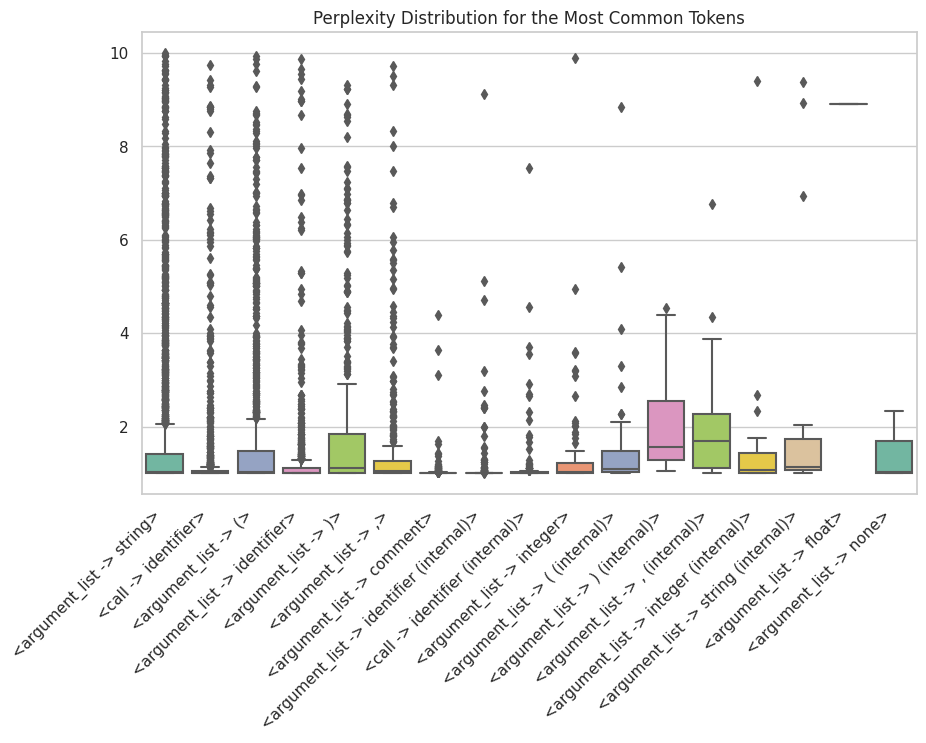

In [29]:
#|eval: false
# boxplot the distribution of perplexities for the most common tokens
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")

# most_common = token_cnt.most_common(15)
most_common_tokens = [token for token, _ in most_common]
most_common_perplexities = [
    list(filter(lambda x: x < 10, perplexity_dist[token]))
    for token in most_common_tokens
]

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(data=most_common_perplexities, palette="Set2")
ax.set_xticklabels(most_common_tokens)
ax.set_title("Perplexity Distribution for the Most Common Tokens")
plt.xticks(rotation=45, ha="right")
plt.show()

In [16]:
# most_common = token_cnt.most_common(2_000)
# filter out that don't start with a < and end with a >
most_common = [t for t in token_cnt if "internal" in t[0]][:10]

In [17]:
most_common

[]

In [ ]:
plt.clf()

In [ ]:
#|eval: false
# boxplot the distribution of perplexities for the most common tokens
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")

# most_common = token_cnt.most_common(15)
most_common_tokens = [token for token, _ in most_common]
most_common_perplexities = [
    list(filter(lambda x: x < 10, perplexity_dist[token]))
    for token in most_common_tokens
]

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(data=most_common_perplexities, palette="Set2")
ax.set_xticklabels(most_common_tokens)
ax.set_title("Perplexity Distribution for the Most Common Tokens")
plt.xticks(rotation=45, ha="right")
plt.show()

In [ ]:
#|eval: false
from datasets import load_dataset
from tqdm.auto import tqdm

ds = load_dataset("bigcode/the-stack-smol", data_dir="data/python", split="train")
filtered_ds = ds.filter(lambda example: len(example["content"]) < 4096)
repo_names = set(filtered_ds["repository_name"])

repo_files = {}
for repo_name in tqdm(repo_names, desc="Processing repos", total=len(repo_names)):
    rows_w_repo = filtered_ds.filter(lambda example: example["repository_name"] == repo_name)

    if len(rows_w_repo) > 1:
        repo_files[repo_name] = [row["content"] for row in rows_w_repo]
        if len(repo_files) > 100:
            break

`=======`

In [ ]:
# from datasets import load_dataset

# dataset = load_dataset(
#   "codeparrot/github-code",
#   split="train",
#   streaming=True,
#   languages=["Python"],
#   licenses=["gpl-3.0"],
# )
# dataset = load_dataset("bigcode/the-stack-smol", data_dir="data/python", split="train").select(range(5_000))

In [ ]:
# !pip install -U git+https://github.com/ncoop57/code_tokenizers.git
!download_grammars

In [ ]:
1+1

In [1]:
#|eval: false
from datasets import load_dataset
from tqdm.auto import tqdm

ds = load_dataset("bigcode/the-stack-smol", data_dir="data/python", split="train").select(range(5_000))
filtered_ds = ds.filter(lambda example: len(example["content"]) < 4096)

Using custom data configuration bigcode--the-stack-smol-7b51f8bde3058781
Found cached dataset json (/transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab)
Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-b38dcc32a872398b.arrow


In [2]:
len(filtered_ds)

3072

In [3]:
def find_duplicates(items):
  # Create an empty set to store the items that we have already seen
  seen = set()

  # Create an empty list to store the duplicates that we find
  duplicates = []

  # Loop through each item in the list
  for item in items:
    # If the item is already in the "seen" set, then it must be a duplicate
    if item in seen:
      # Add the duplicate to the list
      duplicates.append(item)
    # If the item is not in the "seen" set, then add it to the set
    else:
      seen.add(item)

  # Return the list of duplicates
  return duplicates

In [4]:
repo_names = find_duplicates(filtered_ds["repository_name"])

In [5]:
len(repo_names)

73

In [6]:
repo_files = {}
for repo_name in repo_names:
    rows_w_repo = filtered_ds.filter(lambda example: example["repository_name"] == repo_name)

    if len(rows_w_repo) > 1:
        repo_files[repo_name] = [row["content"] for row in rows_w_repo]
        if len(repo_files) > 100:
            break

Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-0dd594043cdb7dfb.arrow
Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-9e8d9f11675f0fd5.arrow
Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-617ac77a84286d46.arrow
Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b8438b7cad4d94e6ad9378022ce4aab/cache-fa7394602e11c848.arrow
Loading cached processed dataset at /transformers_cache/bigcode___json/bigcode--the-stack-smol-7b51f8bde3058781/0.0.0/e6070c77f18f01a5ad4551a8b7edfba20b

`>>>>>>> da2631218c3ce46078ebd2300a91557e85df83bc`

In [ ]:
len(filtered_ds)

In [ ]:
# filter out repos with only one file
filtered_ds = filtered_ds.filter(lambda example: example["repository_name"] in repo_files)

In [ ]:
len(filtered_ds)

`<<<<<<< HEAD`

In [ ]:
filtered_ds

`=======`

`>>>>>>> da2631218c3ce46078ebd2300a91557e85df83bc`

In [ ]:
#|eval: false
from code_tokenizers.core import CodeTokenizer
from transformers import AutoModelForCausalLM

model_name = "codeparrot/codeparrot-small"
py_tokenizer = CodeTokenizer.from_pretrained(model_name, "python", padding_token="<|endoftext|>")
model = AutoModelForCausalLM.from_pretrained(model_name)
py_tokenizer.tokenizer

`<<<<<<< HEAD`

In [ ]:
#|eval: false
from code_tokenizers.helpers import get_internal_methods

internal_methods = get_internal_methods(repo_files["reduceus/connect-python-sdk"], py_tokenizer)
internal_methods

`=======`

In [11]:
#|eval: false
from code_tokenizers.helpers import get_internal_methods

# internal_methods = get_internal_methods(repo_files["reduceus/connect-python-sdk"], py_tokenizer)
# internal_methods

`>>>>>>> da2631218c3ce46078ebd2300a91557e85df83bc`

In [ ]:
#|eval: false
# add the internal methods to the dataset
filtered_ds = filtered_ds.map(lambda example: {"internal_methods": get_internal_methods(repo_files[example["repository_name"]], py_tokenizer)})

In [ ]:
filtered_ds[1]

In [ ]:
#|eval: false
from transformers import default_data_collator

def code_collator(batch):
    merged_ast = []
    for b in batch:
        merged_ast.append(b.pop("merged_ast"))

    batch = default_data_collator(batch)
    batch["merged_ast"] = merged_ast
    return batch

`<<<<<<< HEAD`

In [ ]:
#|eval: false
from functools import partial
def tokenizer_wrapper(tokenizer, example, column, *args, **kwargs):
    return tokenizer(example[column], internal_methods=example["internal_methods"], *args, **kwargs)
    # return tokenizer(example["content"])

tokenizer = partial(tokenizer_wrapper, py_tokenizer, column="content")

`=======`

In [28]:
#|eval: false
from functools import partial
def tokenizer_wrapper(tokenizer, example, column, *args, **kwargs):
    # print(example["internal_methods"])
    return tokenizer(example[column], internal_methods=example["internal_methods"], *args, **kwargs)
    # return tokenizer(example["content"])

tokenizer = partial(tokenizer_wrapper, py_tokenizer, column="content")

`>>>>>>> da2631218c3ce46078ebd2300a91557e85df83bc`

In [ ]:
tokenizer.decode = py_tokenizer.decode

`<<<<<<< HEAD`

In [ ]:
#|eval: false
from perplexed.core import perplexed

perplexity_dist, token_cnt = perplexed(
    model,
    filtered_ds,
    tokenizer=tokenizer,
    column="content",
    semantic_column="merged_ast",
    batch_size=10,
    num_proc=4,
    device="cpu",
    collate_fn=code_collator,
    pass_row=True,
    return_tokens=True,
    return_distributions=True,
)

In [ ]:
most_common = token_cnt.most_common(2_000)
# filter out that don't start with a < and end with a >
most_common = [t for t in most_common if t[0].startswith("<") and t[0].endswith(">")]

In [ ]:
token_cnt

In [ ]:
[t for t in token_cnt if "internal" in t[0]]

`=======`

In [30]:
#|eval: false
from perplexed.core import perplexed

perplexity_dist, token_cnt = perplexed(
    model,
    filtered_ds,
    tokenizer=tokenizer,
    column="content",
    semantic_column="merged_ast",
    batch_size=1,
    num_proc=4,
    device="cpu",
    collate_fn=code_collator,
    pass_row=True,
    return_tokens=True,
    return_distributions=True,
)

Tokenizing dataset #1:   0%|          | 0/31 [00:00<?, ?ex/s]

Tokenizing dataset #2:   0%|          | 0/31 [00:00<?, ?ex/s]

Tokenizing dataset #0:   0%|          | 0/32 [00:00<?, ?ex/s]

Tokenizing dataset #3:   0%|          | 0/31 [00:00<?, ?ex/s]

Output()

In [47]:
most_common = token_cnt.most_common(2_000)
# filter out that don't start with a < and end with a >
# most_common = [t for t in most_common if t[0].startswith("<") and t[0].endswith(">")]

In [48]:
most_common = [t for t in most_common if "<call -> identifier (internal)>" in t[0] or "<call -> identifier>" in t[0]]

`>>>>>>> da2631218c3ce46078ebd2300a91557e85df83bc`

In [ ]:
most_common

`<<<<<<< HEAD`

In [ ]:
#|eval: false
# boxplot the distribution of perplexities for the most common tokens
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")

# most_common = token_cnt.most_common(15)
most_common_tokens = [token for token, _ in most_common]
most_common_perplexities = [
    list(filter(lambda x: x < 10, perplexity_dist[token]))
    for token in most_common_tokens
]

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(data=most_common_perplexities, palette="Set2")
ax.set_xticklabels(most_common_tokens)
ax.set_title("Perplexity Distribution for the Most Common Tokens")
plt.xticks(rotation=45, ha="right")
plt.show()

`=======`

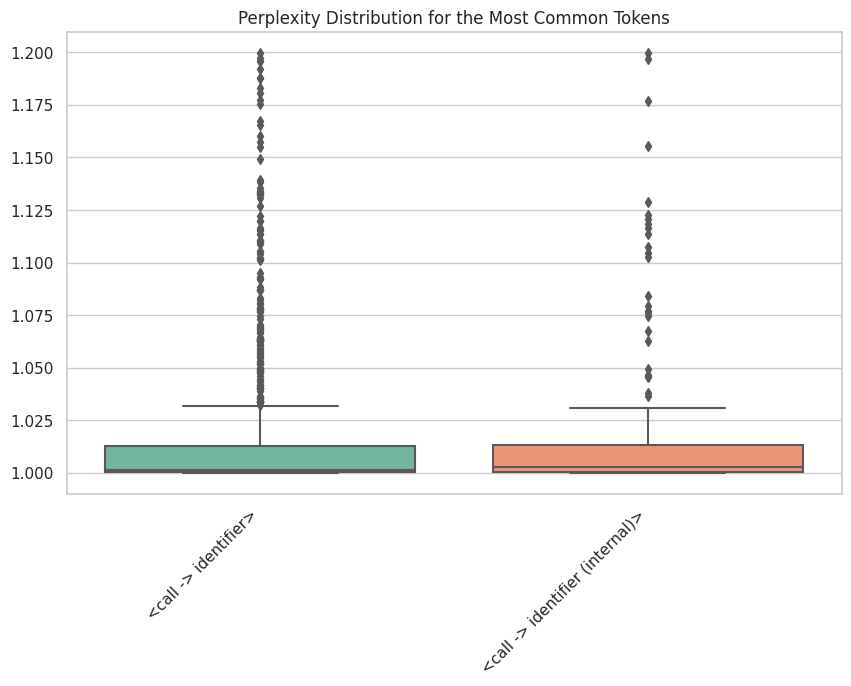

In [56]:
#|eval: false
# boxplot the distribution of perplexities for the most common tokens
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

sns.set_theme(style="whitegrid")

# most_common = token_cnt.most_common(15)
most_common_tokens = [token for token, _ in most_common]
most_common_perplexities = [
    list(filter(lambda x: x < 1.2, perplexity_dist[token]))
    for token in most_common_tokens
]

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.boxplot(data=most_common_perplexities, palette="Set2")
ax.set_xticklabels(most_common_tokens)
ax.set_title("Perplexity Distribution for the Most Common Tokens")
plt.xticks(rotation=45, ha="right")
plt.show()

`>>>>>>> da2631218c3ce46078ebd2300a91557e85df83bc`

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()